In [50]:
# Imports, as always...
import pandas as pd
import numpy as np
from pathlib import Path
import os
import ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

import image_keyword_features
import create_data

import warnings
warnings.filterwarnings('ignore')

---

---

# Updates to RQ1

Testing has shown that there is not much to be learnt from the perceived sentiment of listing images...

In [51]:
data = image_keyword_features.compute_image_sentiments('datasets/image_keywords_edinburgh.csv')

In [52]:
data.sample(5)

,id,mean_sentiment,std_sentiment,extraction_count
4957,7.548924e+17,0.007255,0.033245,22.0
3057,5.091113e+07,0.000000,0.000000,25.0
2600,4.267370e+07,-0.000418,0.003263,62.0
1670,2.776964e+07,0.000000,0.000000,36.0
140,3.572324e+06,-0.000851,0.008253,95.0


In [53]:
data.describe()

,id,mean_sentiment,std_sentiment,extraction_count
count,5.126000e+03,5126.000000,5126.000000,5126.000000
mean,2.104933e+17,0.000508,0.009166,36.997269
std,3.111559e+17,0.003506,0.016253,14.291379
min,2.428800e+04,-0.024214,0.000000,3.000000
25%,2.186357e+07,-0.000541,0.000000,26.000000
50%,4.128565e+07,0.000000,0.000000,36.000000
75%,6.252139e+17,0.000000,0.012170,46.750000
max,7.825218e+17,0.046885,0.159758,99.000000


Looking into associated scores of keywords...

In [54]:
success = pd.read_csv('datasets/master_edinburgh.csv')[['id', 'success_score']]

In [55]:
keywords = create_data.mean_keyword_scores(success, 'datasets/image_keywords_edinburgh.csv')

# Sort the keywords by their associated scores.
keywords = sorted(keywords.items(), key=lambda x:x[1], reverse=True)

In [56]:
keywords[:5]

[('Violin', 2.368272475224936),
 ('Bowling', 1.7261150335977298),
 ('Marching', 1.6372526419469364),
 ('Group Performance', 1.5722201930068291),
 ('Music Band', 1.5216288167990544)]

---

# Updates to RQ2

---

# Updates to RQ3

---

# Miscellaneous Fun

## Data Preprocessing: Cleaning and Selecting

In [57]:
# Create master data for Edinburgh (if not created already).
if not Path('datasets/master_edinburgh.csv').is_file():
    create_data.city_data_generation('edinburgh', 'datasets', datetime(2022, 12, 16), True)
    print('Master data file generated.')

else:
    print('Pre-existing master data file found (no new data created).')

# Note: This takes around 3 minutes on my laptop for ~7500 listings and ~500000 reviews (Edinburgh).

Pre-existing master data file found (no new data created).


In [58]:
# Get the master data.
master_data = pd.read_csv('datasets/master_edinburgh.csv').iloc[:,2:]

In [59]:
# We will be predicting success
# So, it would only be fair for us to remove all data used to generate success scores.
master_data.drop(columns=[
    'price',
    'minimum_nights_avg_ntm', 
    'number_of_reviews_ltm',
    'log_price', 
    'rental_probability',
    'weighted_average_sentiment'
], inplace=True, axis=1)

In [60]:
# Count the number of missing values in each feature.
missing_values = master_data.isna().sum().sort_values(ascending=False)
missing_values

bathrooms                       7389
neighbourhood_group_cleansed    7389
license                         7374
host_neighbourhood              4382
host_about_keywords             3344
                                ... 
availability_30                    0
host_id                            0
availability_90                    0
availability_365                   0
availability_60                    0
Length: 71, dtype: int64

In [61]:
# Drop features with majority missing values.
threshold = master_data.shape[0] // 2
master_data.drop(columns=missing_values[missing_values > threshold].index, inplace=True, axis=1)
print('dropped:', missing_values[missing_values > threshold].index)

dropped: Index(['bathrooms', 'neighbourhood_group_cleansed', 'license',
       'host_neighbourhood'],
      dtype='object')


In [62]:
# Drop rows with missing a succuess score.
print('Number of dropped rows (no success score):', len(master_data[master_data.success_score.isna()]))
master_data = master_data[master_data.success_score.notna()]

Number of dropped rows (no success score): 670


In [63]:
# Remove unhelpful features (for prediction of success).
master_data.drop(columns=[
    'host_id',
    'neighbourhood',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'bathrooms_text',
    'amenities',
    'minimum_minimum_nights', 
    'maximum_minimum_nights',
    'minimum_maximum_nights', 
    'maximum_maximum_nights',
    'maximum_nights_avg_ntm',
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'title_keywords',
    'description_keywords', 
    'neighborhood_overview_keywords',
    'host_about_keywords'
], inplace=True, axis=1) 

# Remove features that almost certinaly don't add anything (e.g. almost all the same value).
master_data.drop(columns=[
    'has_availability',
    'host_has_profile_pic'
], inplace=True, axis=1)

In [64]:
# Helper function for converting dates to days since.
def elapsed_days(from_date_as_string, to_date=datetime(2022, 12, 16)):
    from_date = datetime.strptime(from_date_as_string, '%Y-%m-%d')
    return max(0, (to_date - from_date).days)

In [65]:
# Convert pseudonumeric types (e.g. dates) to numeric...

master_data.host_since = master_data.host_since.apply(elapsed_days)

master_data.host_response_rate = master_data.host_response_rate.apply(
    lambda x : float(x[:-1]) if not pd.isna(x) 
    else x
)

master_data.host_acceptance_rate = master_data.host_acceptance_rate.apply(
    lambda x : float(x[:-1]) if not pd.isna(x) 
    else x
)

master_data.host_verifications = master_data.host_verifications.apply(
    lambda x : len(x)
)

master_data.first_review = master_data.first_review.apply(
    lambda x : elapsed_days(x) if not pd.isna(x)
    else x
)

master_data.last_review = master_data.last_review.apply(
    lambda x : elapsed_days(x) if not pd.isna(x)
    else x
)

In [66]:
# Another look at missing data.
master_data.isna().sum().sort_values(ascending=False)

host_about_polarity                   2678
host_about_subjectivity               2678
images_confidences                    2091
images_keywords                       2091
neighborhood_overview_subjectivity    1823
neighborhood_overview_polarity        1823
host_response_time                    1313
host_response_rate                    1313
host_acceptance_rate                   591
bedrooms                               103
beds                                    59
description_subjectivity                52
description_polarity                    52
review_scores_value                     13
review_scores_checkin                   13
review_scores_communication             13
review_scores_location                  13
review_scores_cleanliness               13
review_scores_accuracy                  13
instant_bookable                         0
reviews_per_month                        0
title_polarity                           0
title_subjectivity                       0
id         

In [67]:
# Replace missing polarity and subjectivity scores with 0 (i.e. neutral and factual).
master_data.host_about_polarity = master_data.host_about_polarity.fillna(0)
master_data.host_about_subjectivity = master_data.host_about_subjectivity.fillna(0)
master_data.neighborhood_overview_polarity = master_data.neighborhood_overview_polarity.fillna(0)
master_data.neighborhood_overview_subjectivity = master_data.neighborhood_overview_subjectivity.fillna(0)
master_data.description_polarity = master_data.description_polarity.fillna(0)
master_data.description_subjectivity = master_data.description_subjectivity.fillna(0)

# Replace missing host_response_rate, host_acceptance_rate with mean values.
master_data.host_response_rate = master_data.host_response_rate.fillna(master_data.host_response_rate.mean())
master_data.host_acceptance_rate = master_data.host_acceptance_rate.fillna(master_data.host_acceptance_rate.mean()) 

# Replace missing host_response_time with mode values.
master_data.host_response_time = master_data.host_response_time.fillna(master_data.host_response_time.mode().values[0])

In [68]:
# Remove all rows with missing values still remaining.
master_data = master_data.dropna()
master_data

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,...,title_subjectivity,description_polarity,description_subjectivity,neighborhood_overview_polarity,neighborhood_overview_subjectivity,host_about_polarity,host_about_subjectivity,images_keywords,images_confidences,success_score
1,707097,3792,within a day,50.000000,84.0,f,9,16,18,t,...,0.000000,0.000000,0.000000,0.500000,0.650000,0.700000,0.550000,"['Couch', 'Furniture', 'Indoors', 'Interior De...","[99.99188232421875, 56.51210403442383, 99.9908...",1.413482
2,728199,3723,within an hour,100.000000,95.0,t,1,2,18,t,...,0.250000,0.308384,0.471296,0.415789,0.568421,0.539323,0.625000,"['Indoors', 'Interior Design', 'Wood', 'Hardwo...","[99.99758911132812, 99.99758911132812, 100.0, ...",0.398385
3,732008,3720,within an hour,100.000000,99.0,f,6,9,18,t,...,0.000000,0.329877,0.625805,0.000000,0.000000,0.000000,0.000000,"['Pool', 'Water', 'Architecture', 'Building', ...","[99.9551010131836, 99.9551010131836, 99.828170...",1.005116
5,748646,3709,within an hour,100.000000,91.0,f,2,2,32,t,...,0.875000,0.270217,0.464132,0.097917,0.577083,0.100000,0.100000,"['Tub', 'Indoors', 'Interior Design', 'Bathing...","[99.64403533935547, 99.99998474121094, 99.8982...",0.157973
6,749042,3708,within a few hours,100.000000,67.0,t,1,1,18,t,...,0.553571,0.253593,0.500216,0.068561,0.509722,0.180714,0.397857,"['Beach', 'Coast', 'Nature', 'Outdoors', 'Sea'...","[99.9984359741211, 99.9984359741211, 61.348407...",0.066545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7372,303689,4000,within a day,100.000000,100.0,f,1,1,18,f,...,0.273810,0.197143,0.505794,0.000000,0.000000,0.325758,0.550000,"['Floor', 'Flooring', 'Indoors', 'Interior Des...","[65.7539291381836, 57.86531066894531, 99.80908...",0.016928
7375,327159,3973,within an hour,100.000000,99.0,f,8,10,32,t,...,0.483333,0.187048,0.412937,0.288333,0.526373,0.318182,0.625000,"['Lamp', 'Bed', 'Furniture', 'Blanket', 'Home ...","[99.20364379882812, 96.61839294433594, 99.9428...",0.000000
7376,327161,3973,within an hour,100.000000,99.0,f,8,10,32,t,...,0.600000,0.212698,0.406746,0.413889,0.494444,0.318182,0.625000,"['Architecture', 'Building', 'City', 'Urban', ...","[99.9959945678711, 99.9959945678711, 99.950050...",0.180358
7383,361050,3944,within a few hours,100.000000,77.0,t,1,2,18,t,...,0.338393,0.174097,0.466336,0.211859,0.521795,0.093669,0.445172,"['Couch', 'Furniture', 'Animal', 'Cat', 'Mamma...","[99.62174224853516, 99.0238265991211, 97.97054...",0.396916


In [69]:
# Calculate the skewness of the features.
skewness = master_data.skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 1])

# Don't worry about skewness with the success scores or id.
skewness.success_score = 0
skewness.id = 0

minimum_nights                 21.987639
host_total_listings_count      13.849192
host_listings_count            12.079675
beds                            4.765847
last_review                     3.584716
number_of_reviews_l30d          3.419912
number_of_reviews               2.903261
bedrooms                        1.947026
success_score                   1.923548
reviews_per_month               1.882003
accommodates                    1.665009
host_verifications              1.146217
host_acceptance_rate           -3.418289
review_scores_value            -4.787247
review_scores_cleanliness      -4.813737
review_scores_rating           -5.211000
review_scores_location         -5.714130
review_scores_accuracy         -6.161939
review_scores_checkin          -6.204161
host_response_rate             -6.703041
review_scores_communication    -6.921178
dtype: float64


In [70]:
# Deal with positive skewness by performing a square root transformation.
for skew_feature in skewness[skewness > 1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 1/2)

# Deal with negative skewness by performing a square transformation.
for skew_feature in skewness[skewness < -1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 2)

In [71]:
# Re-assess skewness.
skewness = master_data.skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 1])

# Don't worry about skewness with the success scores.
skewness.success_score = 0
skewness.id = 0

minimum_nights                 12.427903
host_total_listings_count       6.118373
host_listings_count             5.840698
last_review                     2.146830
success_score                   1.923548
beds                            1.691415
number_of_reviews               1.223847
bedrooms                        1.211955
host_verifications              1.146217
host_acceptance_rate           -2.259816
review_scores_value            -2.879453
review_scores_cleanliness      -2.955166
review_scores_rating           -3.158199
review_scores_location         -3.337822
review_scores_accuracy         -4.173582
review_scores_checkin          -4.192822
review_scores_communication    -4.433025
host_response_rate             -4.820845
dtype: float64


In [72]:
# Deal with positive skewness AGAIN by performing a square root transformation AGAIN (i.e. fourth root).
for skew_feature in skewness[skewness > 1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 1/2)

# Deal with negative skewness AGAIN by performing a square transformation AGAIN (i.e. to power 4).
for skew_feature in skewness[skewness < -1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 2)

In [73]:
# Re-assess skewness.
skewness = master_data.skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 1])

# Don't worry about skewness with the success scores.
skewness.success_score = 0

minimum_nights                 6.542786
host_total_listings_count      3.227918
host_listings_count            3.074636
success_score                  1.923548
last_review                    1.312855
number_of_reviews              1.223847
bedrooms                       1.211955
host_verifications             1.146217
beds                           1.064982
review_scores_value           -1.484792
host_acceptance_rate          -1.504017
review_scores_cleanliness     -1.701300
review_scores_rating          -1.724619
review_scores_location        -1.930659
review_scores_accuracy        -2.541275
review_scores_communication   -2.731764
review_scores_checkin         -2.742524
host_response_rate            -3.435799
dtype: float64


In [74]:
# Convert categorical (e.g. boolean) types to numeric...

master_data.host_response_time = master_data.host_response_time.map(
    lambda x : {'within an hour' : 1, 'within a few hours' : 2, 'within a day' : 3, 'a few days or more' : 4}.get(x, 0)
)

master_data.host_is_superhost = master_data.host_is_superhost.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

master_data.host_identity_verified = master_data.host_identity_verified.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

master_data.room_type = master_data.room_type.map(
    lambda x : {'Entire home/apt' : 1, 'Private room' : 2, 'Hotel room' : 3, 'Shared room' : 4}.get(x, 0)
)

master_data.instant_bookable = master_data.instant_bookable.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

<AxesSubplot: >

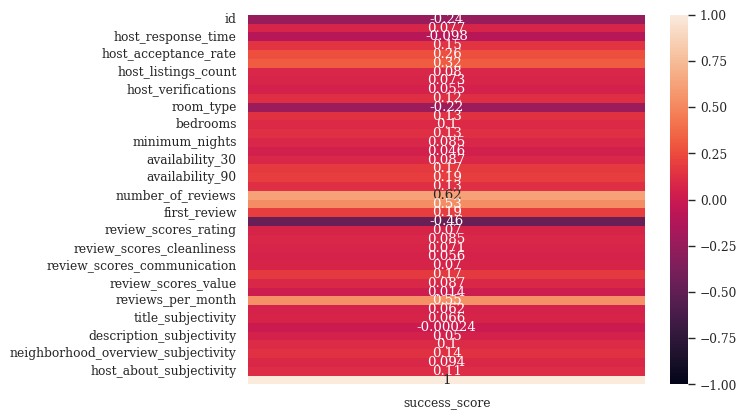

In [75]:
# Show the correlations with success.
corr = master_data.corr()[['success_score']]
sns.heatmap(corr, annot=True, vmin=-1, vmax=1)

## Data Preprocessing: Creating New Features

From the mean scores of each image keyword, come up with an average scoring of the extracted keywords for each listing. That is, from the calculated success scores of each extracted image keywords, calcualted the perceived success in the images.

We will weight this average using the confidence scores (e.g. if we are 87% confident in the keyword "window", and "window" has an average score of 1.0, then the contribution of "window" to the perceived image score of all listings it appears in is 1.0 * 0.87 = 0.87).

In [76]:
# Calcualte the success of the image keywords.
keyword_success = create_data.mean_keyword_scores(master_data[['id', 'success_score']], 'datasets/image_keywords_edinburgh.csv')

In [77]:
# For each listing, compute the mean and standard deviation in the perceived success of image keywords.
weighted_image_score = []
std_image_score = []

for i in range(len(master_data.index)):
    entry = master_data.iloc[i]

    keywords = ast.literal_eval(entry.images_keywords)
    confidences = ast.literal_eval(entry.images_confidences)

    scores = []
    for j in range(len(keywords)):
        scores.append(keyword_success[keywords[j]] * (confidences[j] / 100)) 

    weighted_image_score.append(np.mean(scores))
    std_image_score.append(np.std(scores))

master_data['weighted_image_score'] = weighted_image_score
master_data['std_image_score'] = std_image_score

In [78]:
master_data.weighted_image_score.describe()

count    4512.000000
mean        0.241897
std         0.019780
min         0.166513
25%         0.228378
50%         0.241937
75%         0.255069
max         0.332465
Name: weighted_image_score, dtype: float64

In [79]:
master_data.std_image_score.describe()

count    4512.000000
mean        0.071370
std         0.009856
min         0.019068
25%         0.066316
50%         0.071424
75%         0.076109
max         0.283210
Name: std_image_score, dtype: float64

We would like to compare successful listings with unsuccessful listings. So let's split the data into listings that are more successful than average and listings that are less successful than average.

In [80]:
# Create better_than_average feature
master_data['better_than_average'] = master_data.success_score > np.mean(master_data.success_score)

## Having a Wee Explore

In [81]:
# Beautification.
sns.set_style('darkgrid')
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper')
sns.set_palette('Set2')

Investigating differences between the distribution of features between more and less successful listings.

### Weight Image Score

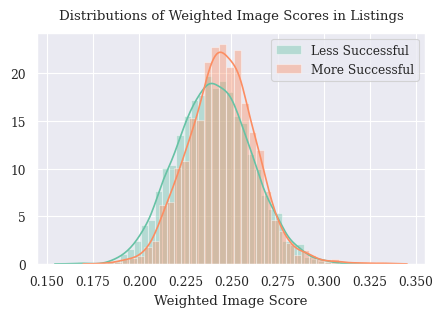

In [82]:
fig, ax = plt.subplots(figsize=(5, 3))

less_sample = master_data[master_data.better_than_average == False].weighted_image_score
more_sample = master_data[master_data.better_than_average == True].weighted_image_score

sns.distplot(less_sample, 
             ax=ax, label='Less Successful')
sns.distplot(more_sample, 
             ax=ax, label='More Successful')

ax.legend()
ax.set_title("Distributions of Weighted Image Scores in Listings", pad=10)
ax.set_ylabel("")
ax.set_xlabel("Weighted Image Score")

fig.savefig('figures/weighted_image_scores_disctribution_comparison.pdf', 
            dpi=300, format='pdf', bbox_inches='tight', facecolor='white')

In [83]:
print("Number of more successful listings:", len(more_sample))
print("Number of less successful listings:", len(less_sample))
print("Hence, total:", len(more_sample) + len(less_sample))

Number of more successful listings: 1547
Number of less successful listings: 2965
Hence, total: 4512


Performing the two-sample one-tailed student's t-test to find whether the mean of the *more* distrubtion is greater than the mean of the *less* distribution...

In [84]:
sig_level = 0.01

_, double_p = ttest_ind(more_sample, less_sample, equal_var=False)

if np.mean(more_sample) > np.mean(less_sample):
    p_value = double_p / 2

else:
    p_value = 1 - (double_p / 2)

print("p-value for the two-sample one-tailed student's t-test:", p_value)

if p_value < sig_level:
    print("Hence, we can reject the null hypothesis (that the means are equal).")

else:
    print("Hence, we cannot reject the null hypothesis (that the means are equal)")

p-value for the two-sample one-tailed student's t-test: 6.746079414665182e-14
Hence, we can reject the null hypothesis (that the means are equal).
